# CodeChallenge: QWERTIES MULTI-OUTPUT ANN CLASSIFICATION

## **Pasos a seguir:**

### - Integrar los notebooks the qwerties classification y multioutput iris

### - Crear 3 grupos (categorías) de qwerties y entrenar una ANN de 3 outputs para clasificarlos

### - Definir la arquitectura que desearemos usar ejemplo (2-4-3 capas (2 nodos entrada)-(4 nodos ocultos)-(3 nodos salida))

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
plt.style.use("dark_background")

### - Generamos los datos para la clasificación binaria que se usará en el experimento

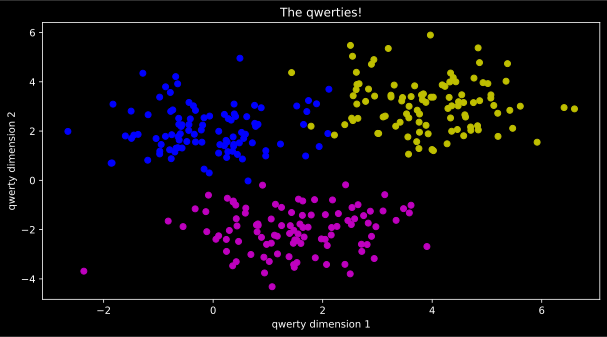

In [210]:
n_per_clust = 100 #número de datos que habrán alrededor de cada centro de categoría
blur = 1 #std, indica cómo de "dispersos" estarán los datos

#coordenadas de la nube de datos de cada categoría (solo eje x)
A = [  0, 2 ] #el centro de la categoría A (x=1,y=3)
B = [  4, 3 ] #el centro de la categoría B (x=5,y=1)
C = [  1.5, -2 ] #el centro de la categoría C (x=5,y=1)

# generar datos aleatorios o "ruido" alrededor de cada centro (A,B)
a = [ A[0]+np.random.randn(n_per_clust)*blur , A[1]+np.random.randn(n_per_clust)*blur ]
b = [ B[0]+np.random.randn(n_per_clust)*blur , B[1]+np.random.randn(n_per_clust)*blur ]
c = [ C[0]+np.random.randn(n_per_clust)*blur , C[1]+np.random.randn(n_per_clust)*blur ]


# true labels
#para las etiquetas, asignamos ceros a la categoría A, y 1 a la categoría B
labels_np = np.vstack((np.zeros((n_per_clust,1)),np.ones((n_per_clust,1)), np.ones((n_per_clust,1))*2))

# concatenamos los datos aleatorios en una matriz traspuesta
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.squeeze(torch.tensor(labels_np).long()) #convertimos a vector las etiquetas

# show the data
fig = plt.figure(figsize=(10,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bo')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'yo')
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'mo')

plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [211]:
model = nn.Sequential(

    nn.Linear(data.shape[1], 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6,len(labels.unique()))
)

In [212]:
model

Sequential(
  (0): Linear(in_features=2, out_features=12, bias=True)
  (1): ReLU()
  (2): Linear(in_features=12, out_features=6, bias=True)
  (3): ReLU()
  (4): Linear(in_features=6, out_features=3, bias=True)
)

In [213]:
n_epochs = 1000
learning_rate = 0.1

loss_func = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=model.parameters(), lr=learning_rate)

In [214]:
losses = torch.zeros(n_epochs) #para almacenar las pérdidas para cada epoch
accuracies = []
category_accs = torch.zeros(n_epochs, len(labels.unique()))

In [215]:
labels.shape

torch.Size([300])

In [216]:
for epoch in tqdm(range(n_epochs)):
    
    #forward pass
    y_hat = model(data)

    #compute error
    loss = loss_func(y_hat, labels)
    losses[epoch] = loss

    #backward pass
    optim.zero_grad() #clear previous gradients cache
    loss.backward() #compute gradients based on the error
    optim.step() #update parameters
    
    #calculamos la precisión
    matches = torch.argmax(y_hat, axis=1) == labels #obtenemos para cada output del modelo, el índice de la salida más alta -> categoría
    matches_num = matches.float()
    
    matches0 = torch.argmax(y_hat, axis=1)[torch.where(labels==0)] == 0
    matches1 = torch.argmax(y_hat, axis=1)[torch.where(labels==1)] == 1
    matches2 = torch.argmax(y_hat, axis=1)[torch.where(labels==2)] == 2
    
    matches0_num, matches1_num, matches2_num = matches0.float(), matches1.float(), matches2.float()
    
    #la media de predicciones acertadas multiplicada por 100
    acc_pct_cat0, acc_pct_cat1, acc_pct_cat2 = 100*torch.mean(matches0_num), 100*torch.mean(matches1_num), 100*torch.mean(matches2_num)    
    
    category_accs[epoch, 0], category_accs[epoch, 1], category_accs[epoch, 2] = acc_pct_cat0, acc_pct_cat1, acc_pct_cat2
    
    accuracies.append(100*torch.mean(matches_num))

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 899.28it/s]


In [217]:
#"final forward pass" - post entrenamiento
preds = model(data)
    
matches = (torch.argmax(preds, axis=1) == labels).float()
total_acc = 100*torch.mean(matches)
    
acc_pct_cat0, acc_pct_cat1, acc_pct_cat2 = 100*torch.mean((matches0).float()), 100*torch.mean((matches1).float()), 100*torch.mean((matches2).float())   

print(f"Final model accuracy ({total_acc:.2f}% total):\n"
     f"- Class A: {acc_pct_cat0}%\n"
     f"- Class B: {acc_pct_cat1}% \n"
     f"- Class C: {acc_pct_cat2}%")

Final model accuracy (99.00% total):
- Class A: 99.0%
- Class B: 98.0% 
- Class C: 100.0%


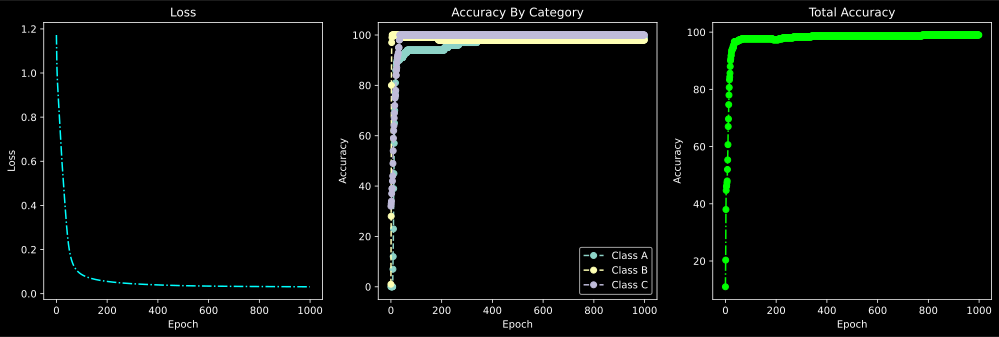

In [218]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(17,5), sharex=True)

axs[0].plot(losses.detach(), "-.",color="cyan"); #"o"
axs[0].set_title("Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")


axs[1].plot(category_accs[:,0], "o--"); #, "o--"
axs[1].plot(category_accs[:,1], "o--"); #, "o--"
axs[1].plot(category_accs[:,2], "o--"); #, "o--"
axs[1].legend(["Class A", "Class B", "Class C"]);


axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy");
axs[1].set_title("Accuracy By Category")

axs[2].set_title("Total Accuracy")
axs[2].set_xlabel("Epoch")
axs[2].set_ylabel("Accuracy")
axs[2].plot(accuracies, "o-.",color="lime"); #"o--"

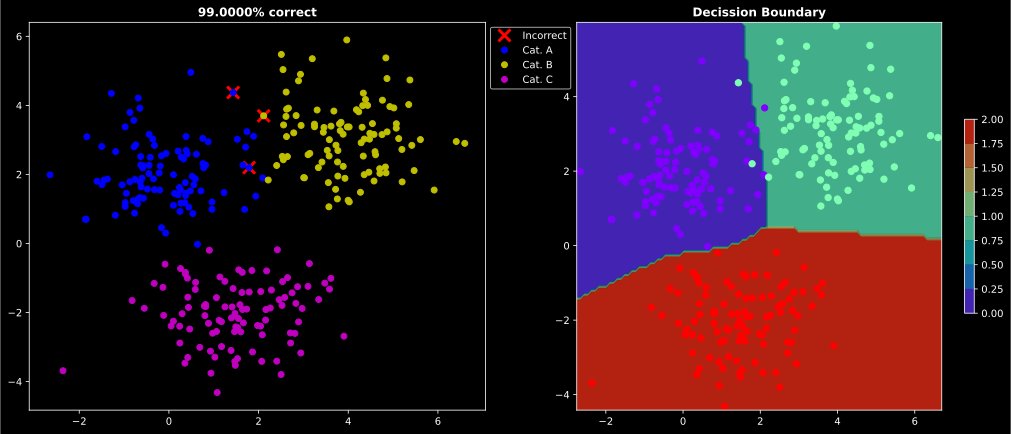

In [219]:
pred_labels = torch.argmax(preds, axis=1)
misclassified = np.where(pred_labels != labels)[0]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,7))

#generamos "X" para la categoria A,B, indexando en los índices donde el modelo no acertó
axs[0].plot(data[misclassified,0] ,data[misclassified,1],'rx',markersize=12,markeredgewidth=3)


#usando el operador "~" invertimos los resultados (si indexamos por los pred_labels, obtenemos los puntos con probabilidad > 0.5, categoria B)
#pero como deseamos trazar los de la categoria A, buscamos las que no son 0.5
axs[0].plot(data[np.where(pred_labels == 0)[0],0],data[np.where(pred_labels == 0)[0],1],'bo') #trazamos los puntos indexados para las predicciones de la categoria A

axs[0].plot(data[np.where(pred_labels == 1)[0],0] ,data[np.where(pred_labels == 1)[0],1], 'yo') #y por último, trazamos los de la categoría B (usando [filas, col])

axs[0].plot(data[np.where(pred_labels == 2)[0],0] ,data[np.where(pred_labels == 2)[0],1], 'mo') #y por último, trazamos los de la categoría B (usando [filas, col])


axs[0].legend(['Incorrect','Cat. A','Cat. B', "Cat. C"],bbox_to_anchor=(1,1))
axs[0].set_title(f'{total_acc:.4f}% correct', fontweight="bold")

x_min, x_max = data[:, 0].min() - 0.1, data[:,0].max() + 0.1
y_min, y_max = data[:, 1].min() - 0.1, data[:, 1].max() + 0.1
 
xx, yy = np.meshgrid(np.linspace(x_min,x_max, 100), np.linspace(y_min, y_max, 100))
 
x_in = np.c_[xx.ravel(), yy.ravel()] 
 
x_in = torch.tensor(np.array([x_in])).float()
 
y_pred = model(x_in)
 
y_pred = torch.argmax(y_pred[0,:,:], axis=1).reshape(xx.shape) 
# plt.figure(figsize=(15,7));
im = axs[1].contourf(xx, yy, y_pred, cmap="rainbow", alpha=0.7 ); #rainbow / cmap=plt.cm.binary_r
axs[1].scatter(data[:,0], data[:, 1], c=labels, s=40, cmap="rainbow"); #rainbow / cmap="Paired"
axs[1].set_xlim(xx.min(), xx.max());
axs[1].set_ylim(yy.min(), yy.max());
axs[1].set_title("Decission Boundary", fontweight="bold")
# axs[1].set_colorbar(shrink=0.5);
fig.colorbar(im, ax=axs[1], shrink=0.5)
plt.subplots_adjust(wspace=0.2, hspace=0.2)

plt.show()

In [220]:
softmax_func = nn.Softmax(dim=1)

In [221]:
softmax_preds = softmax_func(preds)

In [222]:
torch.sum(softmax_func(preds), axis=1)[:3]

tensor([1., 1., 1.], grad_fn=<SliceBackward0>)

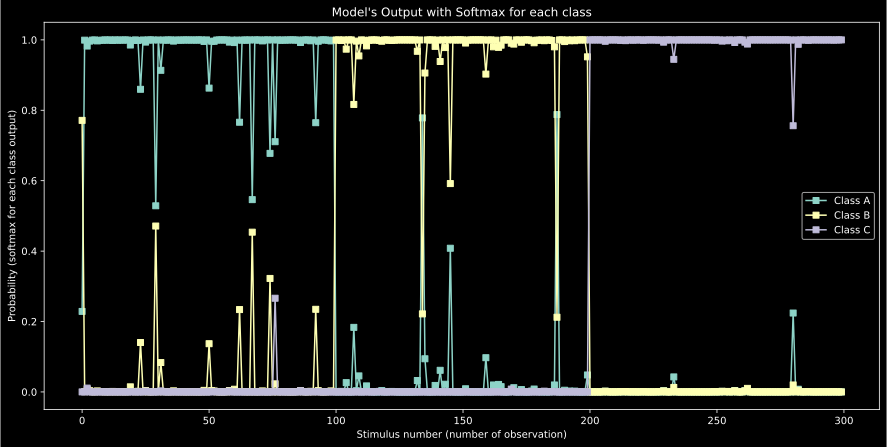

In [225]:
fig = plt.figure(figsize=(15,7))
plt.title("Model's Output with Softmax for each class")
plt.plot(softmax_func(preds).detach(), "s-") #'s-',markerfacecolor='w'
plt.xlabel('Stimulus number (number of observation)')
plt.ylabel('Probability (softmax for each class output)')
plt.legend(['Class A','Class B','Class C'])
plt.show()

In [232]:
#aunque usemos softmax explícitamente, obtenemos los mismos resultados usando argmax
(torch.argmax(preds, axis=1) == torch.argmax(softmax_func(preds), axis=1))[:3]

tensor([True, True, True])

________

## Additional Explorations C:\Users\pablo\Mi unidad\Neural Networks\resources\courses\Udemy\A deep understanding of deep learning (with Python intro) - Mike X Cohen\code\ANN\DUDL_ANN_codeChallengeQwerties.ipynb

In [233]:
# 1) Does the model always do well? Re-run the entire notebook multiple times and see if it always reaches high accuracy
#    (e.g., >90%). What do you think would be ways to improve the performance stability of the model?
#

In [565]:
# 2) You'll learn in the section "Metaparameters" that CrossEntropyLoss computes log-softmax internally. Does that mean 
#    that the Softmax() layer in the model needs to be there? Does it hurt or help? If you remove that final layer, what
#    would change and what would be the same in the rest of the notebook?
#    (Note about this problem: If it feels too advanced, then revisit this problem after the "Metaparameters" section.)
# 

#will make the same effect, but innecesary because it already does internally that operation

____